In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d aaaof96/mango-object-detection
!unzip mango-object-detection.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 29.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110701 sha256=873ca81848bc2c42a76ff583e4b18b8e2cb343684dd9298827b54ded5dacab74
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
100%|███████████████████████████████████████▉| 853M/855M [00:21<00:00, 43.4MB/s]
100%|████████████████████████████████████████| 855M/855M [00:21<00:00, 42.5MB/s]
Archive:  mango-object-detection.zip
  inflating: to_train/test/IMG_0991.jpg  
  inflating: to_train/test/IMG_1025.jpg  
  inflating: to_train/test/IMG_1027.jpg  
  inflating: to_train/test/IMG_1081.jpg  
  inflating: to_train/test/IMG_1084.jpg  
  inflating: to_train/test/IMG_1091.jpg  
  inflating: to_train/test/IMG_1103.jpg  
  inflating: to_trai

In [2]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)


torch version: 2.0.1 cuda: True
mmdetection: 3.1.0
mmcv: 2.0.1
mmengine: 0.8.4


In [ ]:
# #clear memory GPU
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [35]:
!mim download mmdet --config mask-rcnn_x101-32x4d_fpn_2x_coco --dest ./checkpoints

processing mask-rcnn_x101-32x4d_fpn_2x_coco...
mask_rcnn_x101_32x4d_fpn_2x_coco_bbox_mAP-0.422__segm_mAP-0.378_20200506_004702-faef898c.pth exists in /workspace/checkpoints
Successfully dumped mask-rcnn_x101-32x4d_fpn_2x_coco.py to /workspace/checkpoints


In [36]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = '/workspace/checkpoints/mask-rcnn_x101-32x4d_fpn_2x_coco.py'
# Setup a checkpoint file to load
checkpoint_file = '/workspace/checkpoints/mask_rcnn_x101_32x4d_fpn_2x_coco_bbox_mAP-0.422__segm_mAP-0.378_20200506_004702-faef898c.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'


Loads checkpoint by local backend from path: /workspace/checkpoints/mask_rcnn_x101_32x4d_fpn_2x_coco_bbox_mAP-0.422__segm_mAP-0.378_20200506_004702-faef898c.pth


In [ ]:
# # Use the detector to do inference
# image = mmcv.imread('/workspace/mmdetection/demo/demo.jpg',channel_order='rgb')
# result = inference_detector(model, image)
# print(result)

### Let's plot the result

In [ ]:
# from mmdet.registry import VISUALIZERS
# # init visualizer(run the block only once in jupyter notebook)
# visualizer = VISUALIZERS.build(model.cfg.visualizer)
# # the dataset_meta is loaded from the checkpoint and
# # then pass to the model in init_detector
# visualizer.dataset_meta = model.dataset_meta

In [ ]:
# # show the results
# visualizer.add_datasample(
#     'result',
#     image,
#     data_sample=result,
#     draw_gt = None,
#     wait_time=0,
# )
# visualizer.show()

In [ ]:
!tree ballondatasets

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/workspace/to_train/train/IMG_1003.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [5]:
mango_train_annotation = mmengine.load("/workspace/to_train/train/annotation_train.json")
mango_val_annotation = mmengine.load("/workspace/to_train/validate/annotation_val.json")
mango_test_annotation = mmengine.load("/workspace/to_train/test/annotation_test.json")

In [6]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '/workspace/to_train/train/annotation_train.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Category ID: 1, Category Name: mango


In [37]:
from mmengine import Config
cfg = Config.fromfile('/workspace/checkpoints/mask-rcnn_x101-32x4d_fpn_2x_coco.py')

In [38]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('mango', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = '/workspace/to_train'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'validate/annotation_val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'validate/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader.dataset.ann_file = 'test/annotation_test.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_evaluator.ann_file =  cfg.data_root+'/'+'test/annotation_test.json'

# cfg.test_dataloader.dataset.ann_file = 'test/annotation_test.json'
# cfg.test_dataloader.dataset.data_root = cfg.data_root
# cfg.test_dataloader.dataset.data_prefix.img = 'test/'
# cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'validate/annotation_val.json'
# cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '/workspace/checkpoints/mask_rcnn_x101_32x4d_fpn_2x_coco_bbox_mAP-0.422__segm_mAP-0.378_20200506_004702-faef898c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 1

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'/workspace/checkpoints/mask-rcnn_x101-32x4d_fpn_2x_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [39]:
import wandb
wandb.init()

In [40]:
vis_backends = [
    dict(type='WandbVisBackend',
         init_kwargs={
            'project': 'mango-object-detection',
            'group': 'maskrcnn-r50-fpn-1x-coco'
         })
]
visualizer = dict(
    type='DetLocalVisualizer',
    vis_backends=vis_backends,
    name='visualizer')

In [43]:
visualizer

{'type': 'DetLocalVisualizer',
 'vis_backends': [{'type': 'WandbVisBackend',
   'init_kwargs': {'project': 'mango-object-detection',
    'group': 'maskrcnn-r50-fpn-1x-coco'}}],
 'name': 'visualizer'}

In [18]:
type(visualizer)

dict

In [41]:
cfg.vis_backends

[{'type': 'LocalVisBackend'}]

In [45]:
cfg.visualizer = visualizer

In [46]:
cfg.visualizer

{'type': 'DetLocalVisualizer',
 'vis_backends': [{'type': 'WandbVisBackend',
   'init_kwargs': {'project': 'mango-object-detection',
    'group': 'maskrcnn-r50-fpn-1x-coco'}}],
 'name': 'visualizer'}

In [47]:
from mmengine.runner import Runner

# build the runner from config
runner = Runner.from_cfg(cfg)
runner.train()

09/13 14:49:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 209652396
    GPU 0: Tesla V100-SXM2-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

wandb: Currently logged in as: apisakch11 (mango-object-detection). Use `wandb login --relogin` to force relogin


09/13 14:49:27 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
09/13 14:49:27 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

Downloading: "https://download.openmmlab.com/pretrain/third_party/resnext101_32x4d-a5af3160.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x4d-a5af3160.pth


Loads checkpoint by local backend from path: /workspace/checkpoints/mask_rcnn_x101_32x4d_fpn_2x_coco_bbox_mAP-0.422__segm_mAP-0.378_20200506_004702-faef898c.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkp

acc,▁▃▄▇▅▇▄▇▇▇▇▇▇▇▆█▇▇▇▇█▇▇▆▆█▇█▇▇███▇█▇▇█▇▇
coco/bbox_mAP,▁▇▇▇█▇▇█▇▇██████████████
coco/bbox_mAP_50,▁▇▇▇██▇█▇█▇▆▇▇██████████
coco/bbox_mAP_75,▁▇██▇█▇▇█▇███▇██████████
coco/bbox_mAP_l,▁▇▇▇██▇█▇▇██████████████
coco/bbox_mAP_m,▁▆▆▇██▇█▇▇▇██▇█▇▇▇▇▇████
coco/bbox_mAP_s,▁▁▁▁▁▁▁▁▁▁▅▁▁▅▁▁▁▁▅██▅██
coco/segm_mAP,▁▆▆▇▇▇▇█▇▇█▇▇▇██████████
coco/segm_mAP_50,▁▇▇▇█▇▇███▇▆▇█▇█▇▇█▇█▇▇▇
coco/segm_mAP_75,▁▆▆▇▇▆▆█▇▆█▇▇▆▇▇▇▇▇▇▇▇▇▇
coco/segm_mAP_l,▁▆▇▇▇▇▇█▇██▇▇▇█▇███▇▇▇▇▇


MaskRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): 

In [51]:
cfg.test_dataloader.dataset.ann_file = 'test/annotation_test.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_evaluator.ann_file =  cfg.data_root+'/'+'test/annotation_test.json'

In [53]:
runner.test()

09/13 15:41:00 - mmengine - INFO - Epoch(test) [10/17]    eta: 0:00:10  time: 1.1506  data_time: 0.5619  memory: 3549  
09/13 15:41:05 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.721
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.765
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

{'coco/bbox_mAP': 0.533,
 'coco/bbox_mAP_50': 0.721,
 'coco/bbox_mAP_75': 0.611,
 'coco/bbox_mAP_s': 0.01,
 'coco/bbox_mAP_m': 0.527,
 'coco/bbox_mAP_l': 0.765,
 'coco/segm_mAP': 0.532,
 'coco/segm_mAP_50': 0.709,
 'coco/segm_mAP_75': 0.607,
 'coco/segm_mAP_s': 0.015,
 'coco/segm_mAP_m': 0.485,
 'coco/segm_mAP_l': 0.79}

In [54]:
cfg.test_dataloader

{'batch_size': 1,
 'dataset': {'ann_file': 'test/annotation_test.json',
  'backend_args': None,
  'data_prefix': {'img': 'test/'},
  'data_root': '/workspace/to_train',
  'pipeline': [{'backend_args': None, 'type': 'LoadImageFromFile'},
   {'keep_ratio': True, 'scale': (1333, 800), 'type': 'Resize'},
   {'type': 'LoadAnnotations', 'with_bbox': True, 'with_mask': True},
   {'meta_keys': ('img_id',
     'img_path',
     'ori_shape',
     'img_shape',
     'scale_factor'),
    'type': 'PackDetInputs'}],
  'test_mode': True,
  'type': 'CocoDataset',
  'metainfo': {'classes': ('mango',), 'palette': [(220, 20, 60)]}},
 'drop_last': False,
 'num_workers': 2,
 'persistent_workers': True,
 'sampler': {'shuffle': False, 'type': 'DefaultSampler'}}

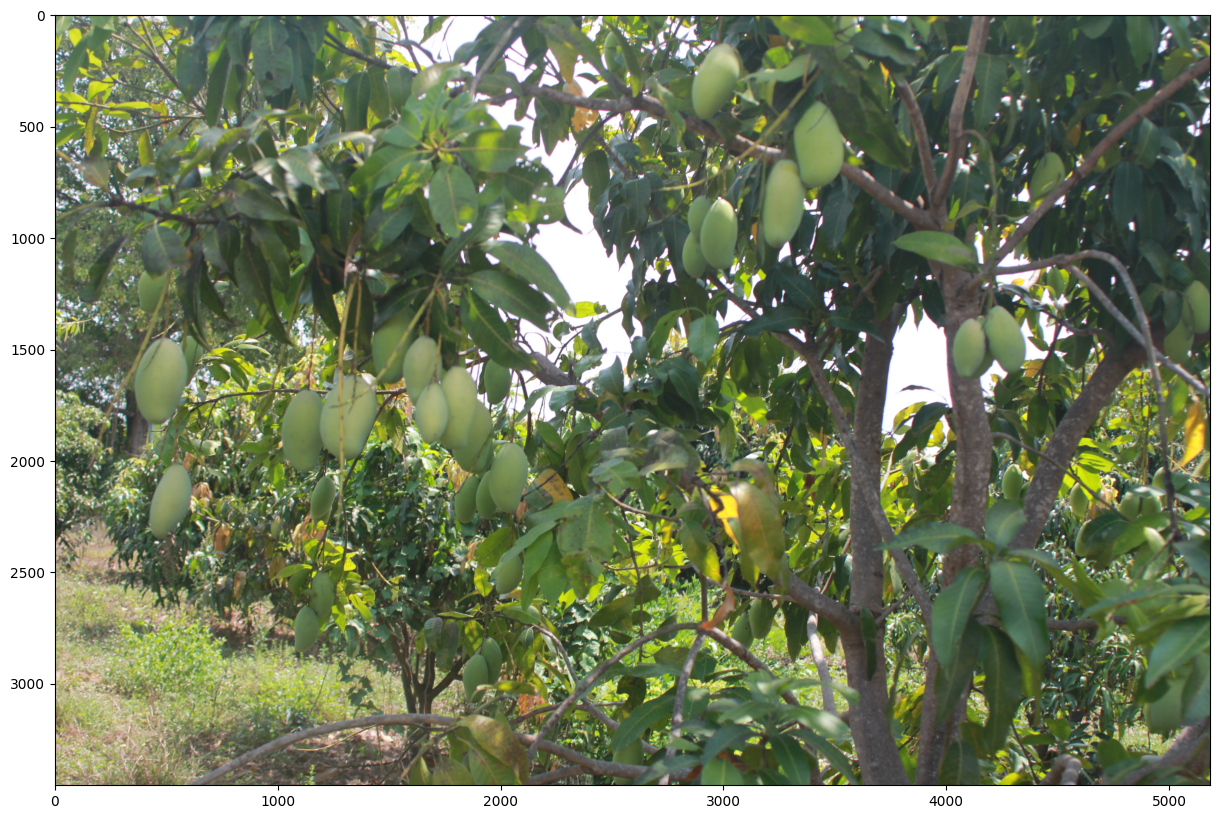

In [55]:
import matplotlib.pyplot as plt
img = mmcv.imread('/workspace/to_train/test/IMG_9428.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [56]:
import mmcv
from mmdet.apis import init_detector, inference_detector

img = mmcv.imread("/workspace/to_train/test/IMG_9428.jpg",channel_order='rgb')
checkpoint_file = '/workspace/tutorial_exps/epoch_24.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)



Loads checkpoint by local backend from path: /workspace/tutorial_exps/epoch_24.pth


In [109]:
score_pred = new_result.pred_instances.scores
count_mango = (score_pred > 0.5).sum().item()
print("count mango: ",count_mango)

count mango:  33


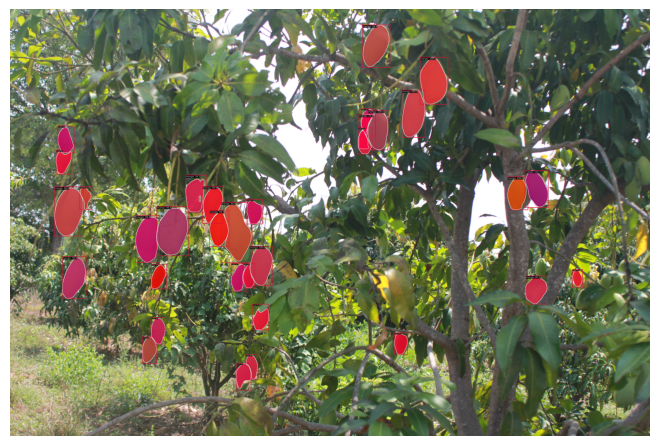

In [112]:
from mmengine.visualization import Visualizer

# get built visualizer
visualizer_now = Visualizer.get_current_instance()

visualizer_now.dataset_meta = model.dataset_meta

visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)

visualizer_now.show()

In [ ]:
wandb.init(project= 'mango-object-detection',
            group= 'maskrcnn-r50-fpn-1x-coco',
          name='fast-leaf-1')

In [113]:
wandb.finish()